Запуск обучения моделей с параметрами как в конфиге TabDDPM на данных, где на категориальных признаках используется OHE. Этот датасет подается TabDDPM как полностью числовой (число категориальных переменных равно 0). Внутри обучения модели на каждом шаге цикла обучения при получении батча происходит добавление шума $N(0, \sigma)$, где $\sigma$ как раз меняется от модели к модели. У первых нескольких моделей она константная, у остальных моделей есть некое ее изменение (постепенное уменьшение). 

Нормализация данных: quantile для числовых метрик и Standart Scaler для OHE

Добавление шума: ко всем

Число эпох обучения: 200'000

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm_ON_QnSC.tabddpm_ON_QnSC import *

from tqdm.notebook import tqdm
import os

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def check_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Cкачиваем и преобразовываем данные

In [3]:
dataname = 'default_ON_QnSC_200k'
model_name = 'tabddpm_ON_QnSC'
model_name_postfix = '_200k'
dataname_initial = 'default'

idx = list(range(10))
constants = [0, 0.001, 0.01, 0.1, 0.25, 0.5]

CONFIG.add_arg('save_cat', None)
target_cat=True
num_steps = 200000

In [4]:
import shutil
try:
    shutil.rmtree(f'./data/{dataname}')
except Exception as e:
    print(e)

with open(f'data/Info/{dataname_initial}.json', 'r') as f:
    info = json.load(f)

info['name'] = dataname
info['data_path'] = f'data/{dataname}/default of credit card clients.xls'
info['task_type'] = 'regression'

with open(f'data/Info/{dataname}.json', 'w', encoding='utf-8') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)

download_dataset(dataname_initial, dataname)

normalizers = categorial_to_OHE(dataname, do_quantile_and_standart_scale=True, target_cat=target_cat)
process_data(dataname)
postprocess_OHE(dataname, dataname_initial, target_cat=target_cat)

Start processing dataset default from UCI.
Finish downloading dataset from https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip, data has been saved to data/default_ON_QnSC_200k.
Finish unzipping default.
n_clusters: 25
n_clusters: 25
n_clusters: 25
{'cat_col_idx': [],
 'cat_col_idx_initial': [14, 15, 16, 17, 18, 19, 20, 21, 22],
 'column_info': {'0': 'float',
                 '10_-1_after_OHE': 'float',
                 '10_-2_after_OHE': 'float',
                 '10_0_after_OHE': 'float',
                 '10_2_after_OHE': 'float',
                 '10_3_after_OHE': 'float',
                 '10_4_after_OHE': 'float',
                 '10_5_after_OHE': 'float',
                 '10_6_after_OHE': 'float',
                 '10_7_after_OHE': 'float',
                 '10_8_after_OHE': 'float',
                 '11': 'float',
                 '12': 'float',
                 '13': 'float',
                 '14': 'float',
                 '15': 'float',
       

In [5]:
from pickle import dump, load

if globals().get('normalizers'):
    dump(normalizers['num_normalizer'], open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'wb'))
    dump(normalizers['cat_normalizer'], open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'wb'))
    
    with open(f'data/{dataname}/normalizers.json', 'w', encoding='utf-8') as f:
        json.dump({
                        'len_num_prev':normalizers['len_num_prev'],
                        'len_cat_prev':normalizers['len_cat_prev'],
                        'len_target_prev':normalizers['len_target_prev'],
                    }, f, ensure_ascii=False, indent=4)
    print(f"normalizers saved to `data/{dataname}` folder")
else:
    with open(f'data/{dataname}/normalizers.json', 'r') as f:
        normalizers = json.load(f)
    normalizers['num_normalizer'] = load(open(f'./data/{dataname}/num_normalizer_{dataname}.pkl', 'rb'))
    normalizers['cat_normalizer'] = load(open(f'./data/{dataname}/cat_normalizer_{dataname}.pkl', 'rb'))
    print(f"normalizers received from `data/{dataname}` folder")

normalizers saved to `data/default_ON_QnSC_200k` folder


### Preparation

In [6]:
with open(f'data/Info/{dataname}.json', 'r') as f:
    info = json.load(f)

In [7]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('save_path', None)
CONFIG.add_arg('sample_save_path', None)

CONFIG.add_arg('mode', 'train')
CONFIG.add_arg('num_noise', info['prev_cat_num'])

CONFIG.add_arg('info_path', None)
CONFIG.add_arg('real_path', None)
CONFIG.add_arg('test_path', None)
CONFIG.add_arg('dataname', None)
CONFIG.add_arg('method', None)
CONFIG.add_arg('device', None)

Device: cuda


In [8]:
CONFIG.get_all_args()

{'dataname': None,
 'method': None,
 'device': None,
 'mode': 'train',
 'train': 1,
 'sample_save_path': None,
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 78,
 'real_path': None,
 'test_path': None,
 'info_path': None,
 'save_path': None,
 'num_clusters': 25,
 'save_cat': None}

### Train

In [16]:
model_save_path_hist = []
for sigma in constants:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
    check_folder(model_save_path)
    model_save_path_hist.append(model_save_path)

    tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=np.ones(200000) * sigma,
                                         dataname=dataname, device=device)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])  
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()
    
    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

In [ ]:
sigmas_list = []

# STEP 1
# 1/3 х 0.5 + 1/3 х 0.1 + 1/3 х 0.01
len_0_5 = num_steps // 3
len_0_1 = num_steps // 3
len_0_01 = num_steps  - len_0_5 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))
# STEP 2
# 1/3 х 0.5 + 1/3 х 0.1 + 1/3 х 0.01
len_0_5 = num_steps // 3
len_0_1 = num_steps // 3
len_0_01 = num_steps  - len_0_5 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# STEP 3
# 1/6 x 0.5 + 1/6 x 0.25 + 0.1 x 1/3 + 0.01 x 1/3
len_0_5 = num_steps // 6
len_0_25 = num_steps // 6
len_0_1 = num_steps // 3
len_0_01 = num_steps  - len_0_5 -len_0_25 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_25)  * 0.25,
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# STEP 4
# 1/8 x 0.5 + 1/8 x 0.25 + 0.1 x 1/4 + 0.01 x 1/2
len_0_5 = num_steps // 8
len_0_25 = num_steps // 8
len_0_1 = num_steps // 4
len_0_01 = num_steps  - len_0_5 -len_0_25 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_25)  * 0.25,
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# STEP 5
# 1/3 х 0.1 + 1/3 х 0.01 + 1/3 х 0.001
len_0_5 = num_steps // 3
len_0_1 = num_steps // 3
len_0_01 = num_steps  - len_0_5 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.1, 
                    np.ones(len_0_1)  * 0.01,
                    np.ones(len_0_01)  * 0.001
                   ]))

# LINEAR 1
# linear from 0.5 to 0.01
sigmas_list.append(np.linspace(0.5, 0.01, num_steps))

# LINEAR 2
# linear from 0.25 to 0.01
sigmas_list.append(np.linspace(0.25, 0.01, num_steps))

# COSINE 1
# cosine from 0.5 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, num_steps)) + 1) * 0.5 / 2)

# COSINE 2
# cosine from 0.25 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, num_steps)) + 1) * 0.25 / 2)

# COSINE 3
# cosine from 0.1 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, num_steps)) + 1) * 0.25 / 2)

In [ ]:
for i, sigmas in zip(idx, sigmas_list):
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    check_folder(model_save_path)
    model_save_path_hist.append(model_save_path)
    
    tabddpm_noise_ohe = TabDDPM_OHE_Noise_QnSC(CONFIG, model_save_path=model_save_path, sigmas=sigmas,
                                         dataname=dataname, device=device)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()

    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

### Draw loss plots

In [17]:
model_save_path_hist = []
for sigma in constants:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)

for i in idx:
    model_save_path=f"./models/{model_name}/ckpt/{dataname_initial}/{model_name}{model_name_postfix}_mult_{i}"
    model_save_path_hist.append(model_save_path)

In [18]:
cmap = get_cmap(len(model_save_path_hist))

/tmp/ipykernel_68681/764837387.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


0it [00:00, ?it/s]

/tmp/ipykernel_68681/748849549.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'total_loss/{dataname_initial}/total_loss_image_{model_name}{model_name_postfix}.png')
/venv/main/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


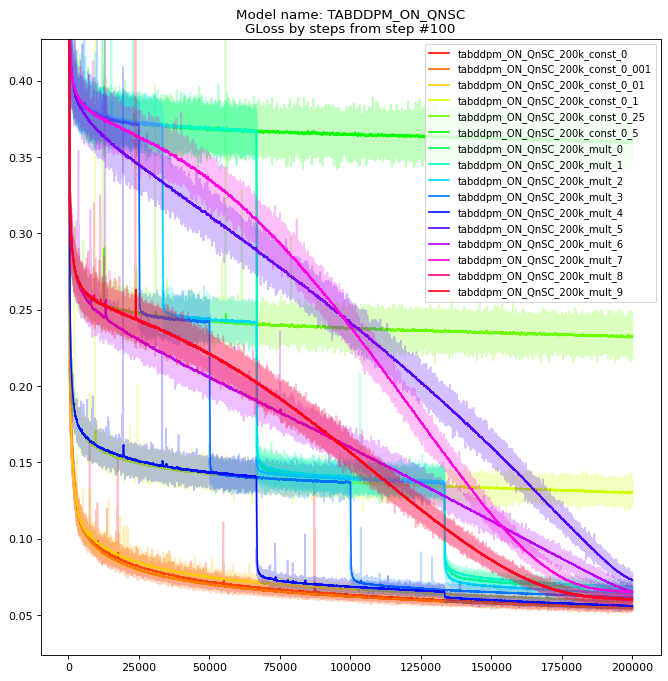

In [19]:
plt.figure(figsize=(10, 10), dpi=80)

max_v, min_v = -np.inf, np.inf
window = 250

for i, model_save_path in tqdm(enumerate(model_save_path_hist)):
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], alpha=0.25, color=cmap(i))

    smoothed = np.convolve(loss['gloss'][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=model_save_path.split('/')[-1], color=cmap(i))

    max_v = np.max([np.quantile(loss['gloss'][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss['gloss'][start_step:], 0.01), min_v])

plt.ylim([min_v-0.03, max_v+0.03])    
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nGLoss by steps from step #{start_step}")

plt.savefig(f'total_loss/{dataname_initial}/total_loss_image_{model_name}{model_name_postfix}.png')

plt.show()

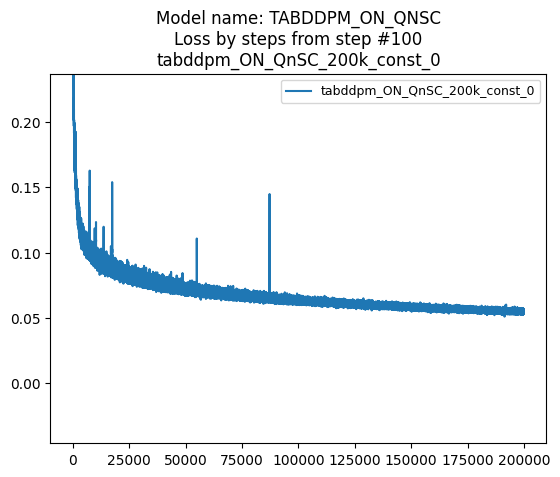

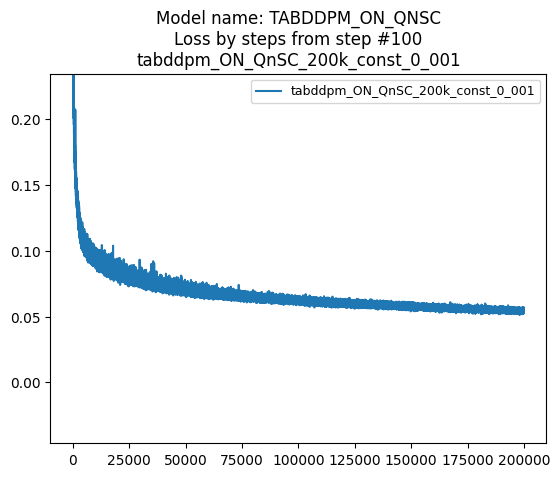

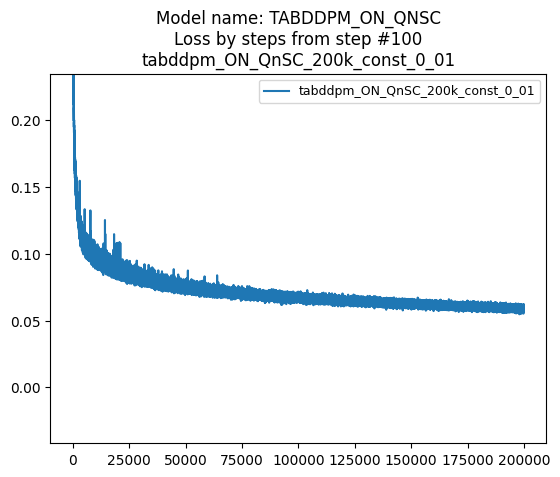

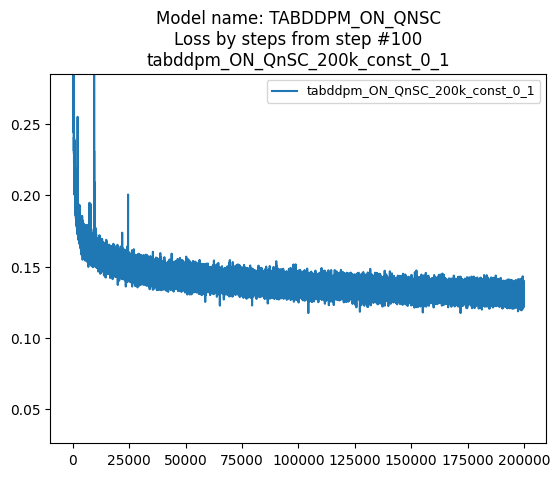

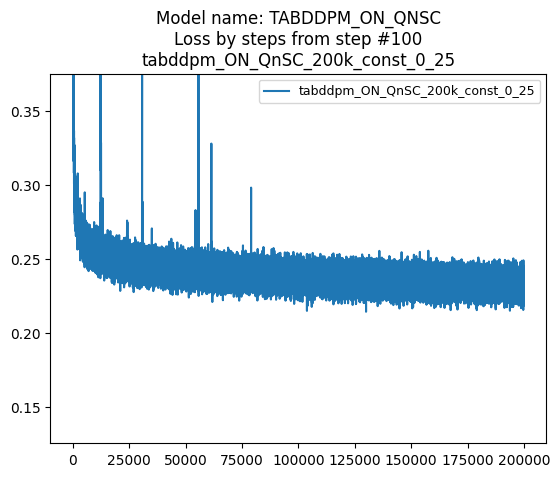

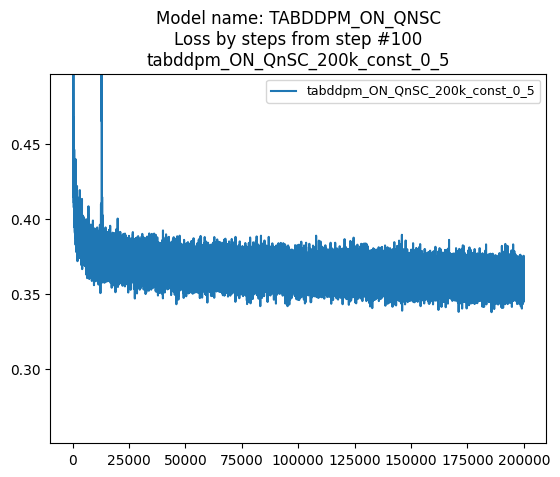

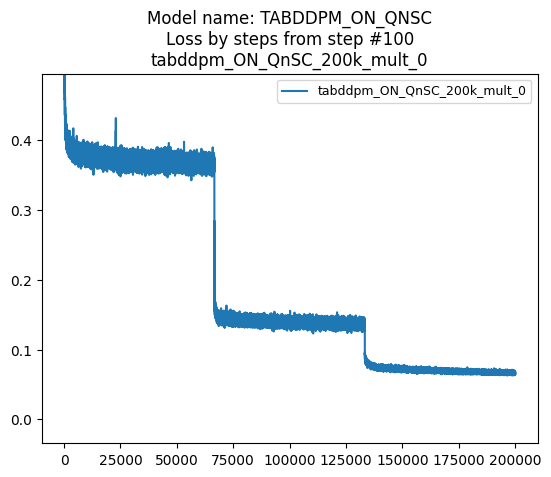

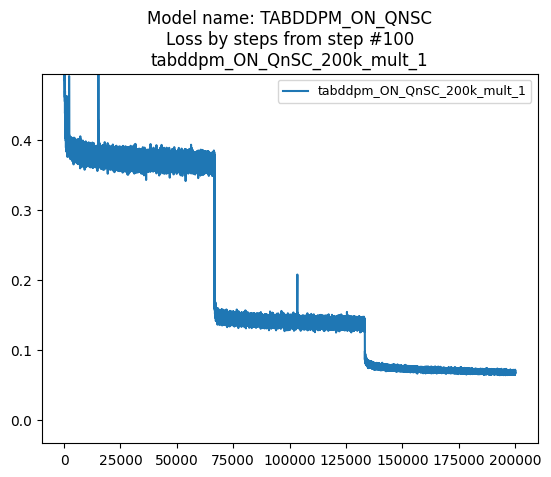

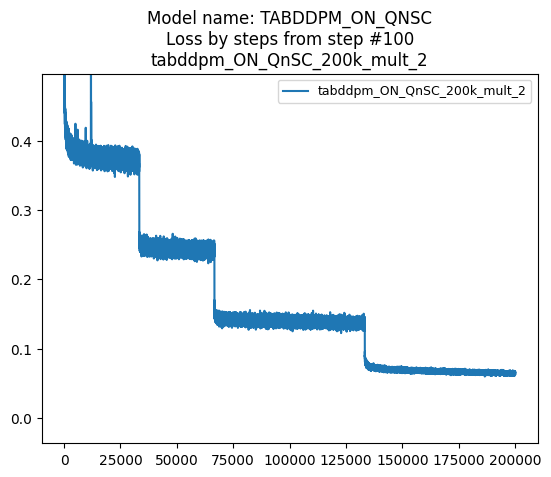

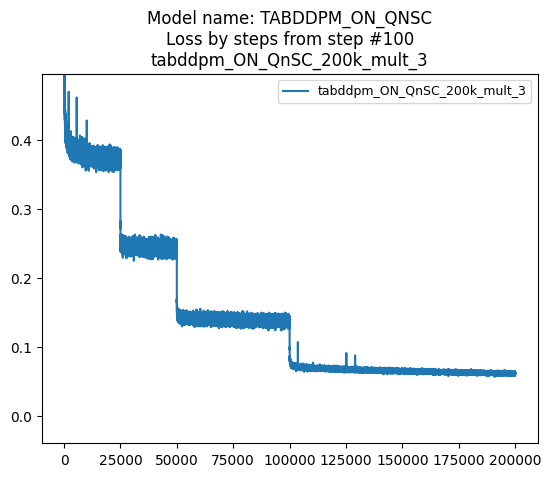

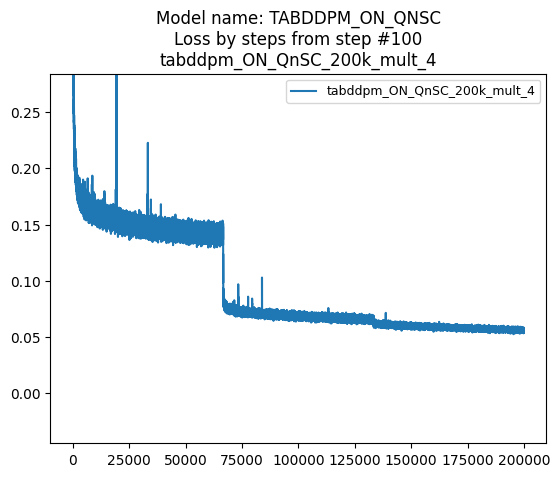

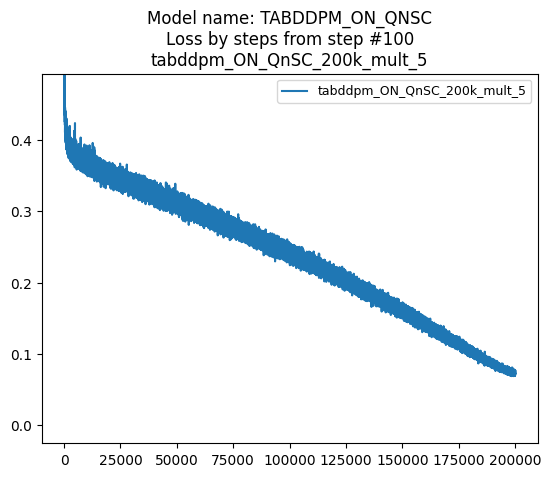

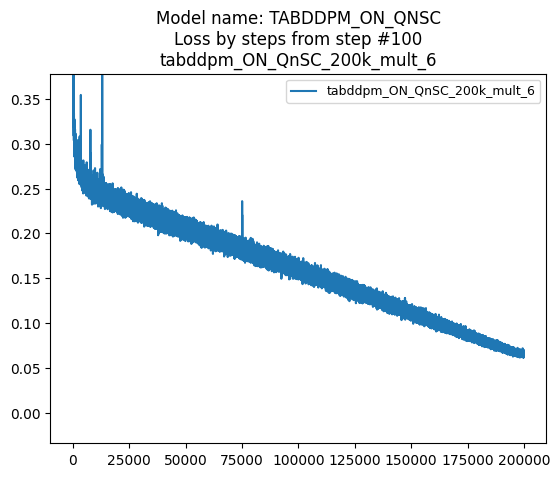

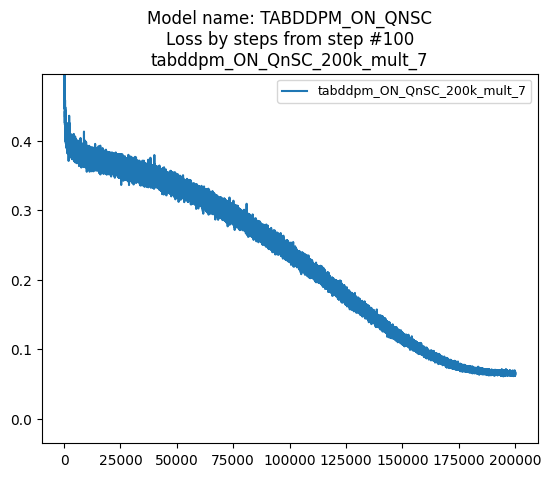

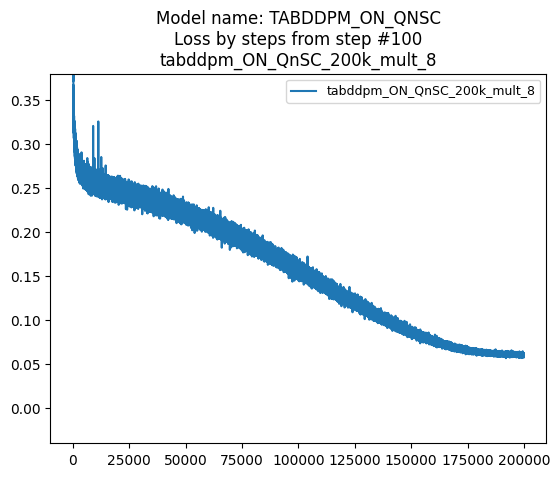

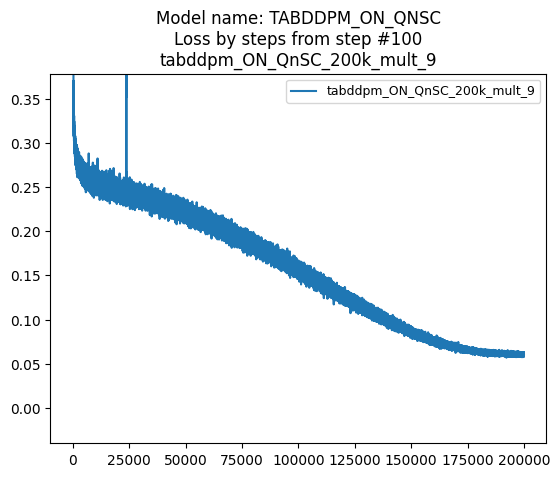

In [20]:
for model_save_path in model_save_path_hist:
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], label=model_save_path.split('/')[-1])

    plt.ylim([np.quantile(loss['gloss'][start_step:], 0.01)-0.1, 
              np.min([2, np.quantile(loss['gloss'][start_step:], 0.99) + 0.1])])    
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    plt.show()